# UTS Topic Modeling - Kelompok 9

**Dataset:** IMDB Movie Reviews

**Tujuan:** Menemukan topik utama pada ulasan film menggunakan LDA. Notebook ini disusun lengkap sesuai template tugas UTS (penjelasan dataset, data understanding, text processing, modeling, visualisasi).

## 1. Penjelasan Dataset

**Kasus yang diambil:** Analisis topik pada ulasan film (movie reviews) dari IMDB.

**Kolom yang tersedia:**
- `review`: teks ulasan pengguna (string)
- `sentiment`: label sentimen (`positive` atau `negative`) — dapat digunakan untuk analisis tambahan tetapi tidak wajib untuk topic modeling.

**Catatan:** Pastikan file `IMDB Dataset.csv` berada di folder yang sama dengan notebook ini.

In [1]:
# === Import library ===
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# NLP utils
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud

# Feature extraction and modeling
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Display settings
%matplotlib inline
sns.set(style='whitegrid')

# Download nltk data (jalankan sekali saja)
nltk.download('stopwords')
nltk.download('wordnet')

ModuleNotFoundError: No module named 'nltk'

## 2. Data Understanding

Lakukan pengecekan jumlah data, panjang rata-rata review, duplikasi, data kosong, serta visualisasi sederhana (distribusi sentimen dan wordcloud).

In [ ]:
df = pd.read_csv('IMDB Dataset.csv')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Jumlah baris data: 50000
Panjang rata-rata review (karakter): 1309.43102
Jumlah duplikasi (baris duplikat): 418
Jumlah NA per kolom:
 review       0
sentiment    0
length       0
dtype: int64


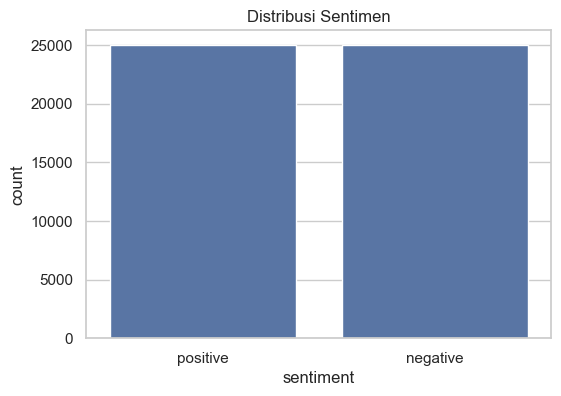

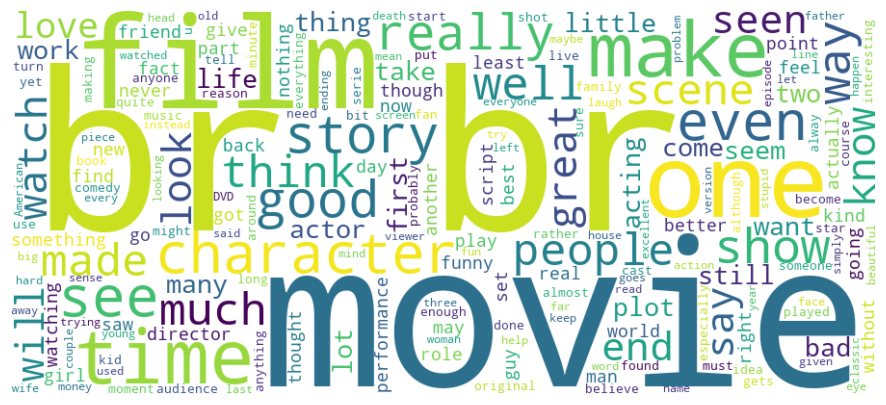

In [ ]:
# Jumlah baris data
print('Jumlah baris data:', len(df))

# Panjang rata-rata setiap review (dalam karakter)
df['length'] = df['review'].apply(len)
print('Panjang rata-rata review (karakter):', df['length'].mean())

# Cek duplikasi dan data kosong
print('Jumlah duplikasi (baris duplikat):', df.duplicated().sum())
print('Jumlah NA per kolom:\n', df.isnull().sum())

# Distribusi sentimen
plt.figure(figsize=(6,4))
sns.countplot(x='sentiment', data=df)
plt.title('Distribusi Sentimen')
plt.show()

# WordCloud (menggabungkan semua review; bisa butuh waktu jika besar)
text_all = ' '.join(df['review'].astype(str).tolist()[:10000])  # gunakan sebagian agar cepat
wc = WordCloud(width=900, height=400, background_color='white').generate(text_all)
plt.figure(figsize=(12,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# Cleaning function
def clean_text(text):
    if not isinstance(text, str):
        return ''
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)       # hapus tag HTML
    text = re.sub(r'[^a-z\s]', ' ', text)   # hanya huruf dan spasi
    text = re.sub(r'\s+', ' ', text)        # hapus spasi berlebih
    return text.strip()

df['clean_text'] = df['review'].apply(clean_text)
df[['review','clean_text']].head()

In [ ]:
# Setup stopwords, lemmatizer, stemmer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess(text):
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words and len(t) > 1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    # Stemming setelah lemmatize (opsional)
    tokens = [stemmer.stem(t) for t in tokens]
    return ' '.join(tokens)

# Terapkan preprocessing (contoh pada sebagian data dulu agar cepat)
df['processed'] = df['clean_text'].apply(preprocess)
df[['clean_text','processed']].head()

,clean_text,processed
0,one of the other reviewers has mentioned that ...,one review mention watch oz episod hook right ...
1,a wonderful little production the filming tech...,wonder littl product film techniqu unassum old...
2,i thought this was a wonderful way to spend ti...,thought wonder way spend time hot summer weeke...
3,basically there s a family where a little boy ...,basic famili littl boy jake think zombi closet...
4,petter mattei s love in the time of money is a...,petter mattei love time money visual stun film...


In [ ]:
# Vectorize (CountVectorizer)
vectorizer = CountVectorizer(max_df=0.95, min_df=5, max_features=3000)
X = vectorizer.fit_transform(df['processed'])

print('Shape dari matrix dokumen-kata:', X.shape)

Shape dari matrix dokumen-kata: (50000, 3000)


In [ ]:
# Latent Dirichlet Allocation (LDA)
n_topics = 5  # ubah sesuai kebutuhan
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, learning_method='batch', max_iter=10)
lda.fit(X)

,n_components,5
,doc_topic_prior,None
,topic_word_prior,None
,learning_method,'batch'
,learning_decay,0.7
,learning_offset,10.0
,max_iter,10
,batch_size,128
,evaluate_every,-1
,total_samples,1000000.0
,perp_tol,0.1


In [ ]:
# Tampilkan kata kunci tiap topik
feature_names = vectorizer.get_feature_names_out()

def show_topics(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_indices]
        topics.append(top_words)
        print(f"Topik {topic_idx+1}: {', '.join(top_words)}\n")
    return topics

topics = show_topics(lda, feature_names, n_top_words=12)

Topik 1: movi, like, one, good, funni, charact, comedi, watch, show, see, make, realli

Topik 2: film, one, man, get, woman, play, scene, go, life, stori, two, take

Topik 3: film, show, one, charact, time, seri, make, war, would, like, episod, well

Topik 4: movi, film, like, one, bad, even, watch, get, make, good, realli, look

Topik 5: film, movi, one, stori, great, see, like, watch, time, love, good, well



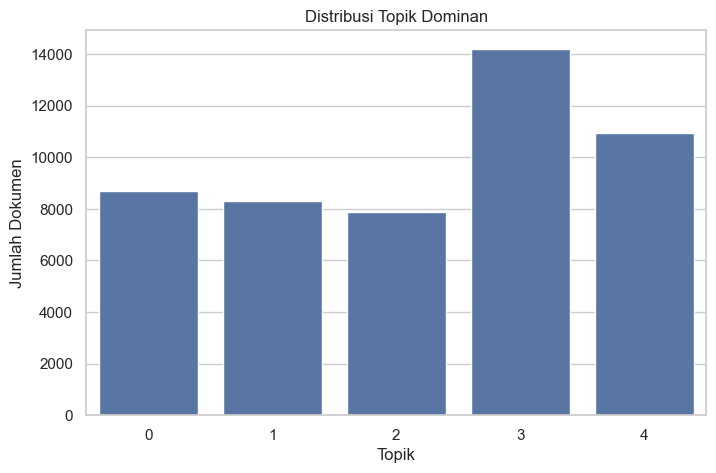


==== Contoh review Topik 1 ====
I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This  ...

==== Contoh review Topik 2 ====
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like i

In [ ]:
# Distribusi topik dominan
topic_values = lda.transform(X)
df['dominant_topic'] = topic_values.argmax(axis=1)

plt.figure(figsize=(8,5))
sns.countplot(x='dominant_topic', data=df)
plt.title('Distribusi Topik Dominan')
plt.xlabel('Topik')
plt.ylabel('Jumlah Dokumen')
plt.show()

# Contoh review untuk setiap topik
for i in range(n_topics):
    sample = df[df['dominant_topic']==i]['review']
    if len(sample) > 0:
        print(f"\n==== Contoh review Topik {i+1} ====")
        print(sample.iloc[0][:500], '...')

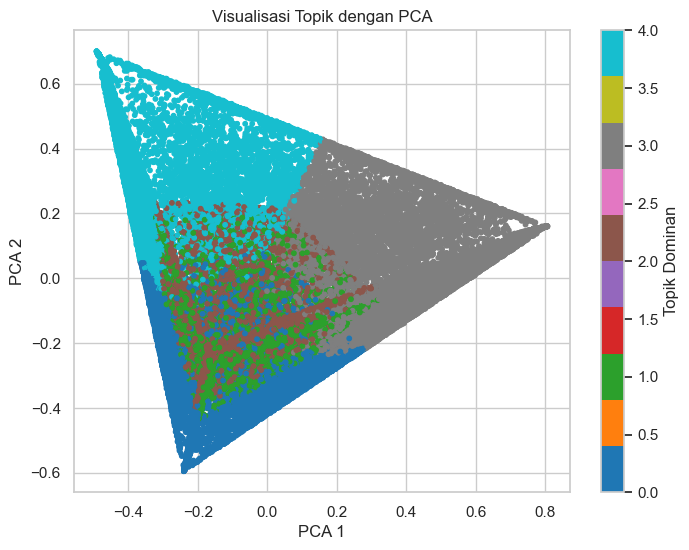

In [ ]:
# Reduksi dimensi dengan PCA
topic_values = lda.transform(X)  # shape: (n_docs, n_topics)
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(topic_values)

plt.figure(figsize=(8,6))
plt.scatter(pca_result[:,0], pca_result[:,1], c=df['dominant_topic'], s=10, cmap='tab10')
plt.title('Visualisasi Topik dengan PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Topik Dominan')
plt.show()

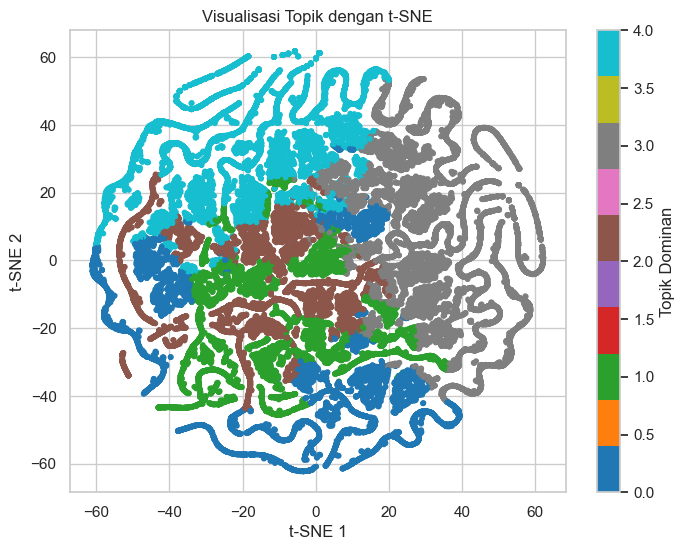

In [ ]:
# Reduksi dimensi dengan t-SNE (lebih lambat, jalankan bila perlu)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=500)
tsne_result = tsne.fit_transform(topic_values)

plt.figure(figsize=(8,6))
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=df['dominant_topic'], s=10, cmap='tab10')
plt.title('Visualisasi Topik dengan t-SNE')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.colorbar(label='Topik Dominan')
plt.show()

In [ ]:
# Simpan hasil topik ke CSV
df[['review','sentiment','dominant_topic']].to_csv('imdb_topics_output.csv', index=False)
print('Hasil disimpan ke imdb_topics_output.csv')

Hasil disimpan ke imdb_topics_output.csv
